# `XTBTSScreener.jl` - Screening Likely Transition States with Julia and Machine Learning
This Jupyter notebook demonstrates the use of machine learning to predict if a partially-optimized initialization of a transition state, used in the study of chemical kinetics to predict rate constants, is _like to converge"_ and produze a valid transition state or not after further simulation with expensive Density Functional Theory simulations.

## Load the Data
The input data is saved in a CSV file, load it using `CSV.jl` and then partition the data into training and testing sets using `MLUtils.jl`.

In [1]:
using MLUtils, CSV

In [2]:
function get_dataloaders()
    csv_reader = CSV.File("data/co2_data.csv")
    n_samples = 313
    x_data = Array{Float32}(undef, 55, 6, n_samples)
    labels = Float32[]
    iter = 1
    for row in csv_reader[1:n_samples]
        # get if it converged or not
        if parse(Bool, "$(row.converged)")
            push!(labels, 1.0f0)
        else
            push!(labels, 0.0f0)
        end

        # get the final coordinates of the atoms
        split_array = split("$(row.std_xyz)")
        n_atoms = Int(length(split_array)/6)
        m = Array{Float32}(undef, 55, 6)
        row_counter = 1
        column_counter = 1
        for value in split_array
            temp = String(value)
            temp = replace(temp,"]"=>"")
            temp = replace(temp,"["=>"")
            temp = replace(temp,","=>"")
            m[row_counter, column_counter] = parse(Float32, temp)
            column_counter += 1
            if column_counter > 6
                column_counter = 1
                row_counter += 1
            end
        end

        # zero-padding
        for i in n_atoms+1:55
            m[i, 1:6] = [0,0,0,0,0,0]
        end
        x_data[1:55, 1:6, iter] = m
        iter += 1
    end
    (x_train, y_train), (x_val, y_val) = splitobs((x_data, labels); at=0.8, shuffle=true)
    return (DataLoader(collect.((x_train, y_train)); batchsize=2^6, shuffle=true),
            DataLoader(collect.((x_val, y_val)); batchsize=2^6, shuffle=false))
end

get_dataloaders (generic function with 1 method)

In [3]:
function get_tutorial_dataloaders()
    dataset_size=1000
    sequence_length=50
    data = [MLUtils.Datasets.make_spiral(sequence_length) for _ in 1:dataset_size]
    # Get the labels
    labels = vcat(repeat([0.0f0], dataset_size ÷ 2), repeat([1.0f0], dataset_size ÷ 2))
    clockwise_spirals = [reshape(d[1][:, 1:sequence_length], :, sequence_length, 1)
                         for d in data[1:(dataset_size ÷ 2)]]
    anticlockwise_spirals = [reshape(d[1][:, (sequence_length + 1):end], :, sequence_length,
                                     1) for d in data[((dataset_size ÷ 2) + 1):end]]
    x_data = Float32.(cat(clockwise_spirals..., anticlockwise_spirals...; dims=3))
    # Split the dataset
    (x_train, y_train), (x_val, y_val) = splitobs((x_data, labels); at=0.8, shuffle=true)
    return (DataLoader(collect.((x_train, y_train)); batchsize=128, shuffle=true),
            DataLoader(collect.((x_val, y_val)); batchsize=128, shuffle=false))
end

get_tutorial_dataloaders (generic function with 1 method)

## Configure the Neural Network
Following from the tutorial in the [Lux documentation](https://lux.csail.mit.edu/stable/examples/generated/beginner/SimpleRNN/main/) we write a series of functions that will create our NN.

In [4]:
using Lux, Random, Optimisers, Zygote, NNlib, Statistics

In [5]:
# Seeding
rng = Random.default_rng()
Random.seed!(rng, 42)

TaskLocalRNG()

In [6]:
struct StateClassifier{L, C} <:
       Lux.AbstractExplicitContainerLayer{(:lstm_cell, :classifier)}
    lstm_cell::L
    classifier::C
end

In [7]:
function StateClassifier(in_dims, hidden_dims, out_dims)
    return StateClassifier(LSTMCell(in_dims => hidden_dims),
                            Dense(hidden_dims => out_dims, sigmoid))
end

StateClassifier

In [8]:
function (s::StateClassifier)(x::AbstractArray{T, 3}, ps::NamedTuple,
                               st::NamedTuple) where {T}
    x_init, x_rest = Iterators.peel(eachslice(x; dims=2))
    (y, carry), st_lstm = s.lstm_cell(x_init, ps.lstm_cell, st.lstm_cell)
    for x in x_rest
        (y, carry), st_lstm = s.lstm_cell((x, carry), ps.lstm_cell, st_lstm)
    end
    y, st_classifier = s.classifier(y, ps.classifier, st.classifier)
    st = merge(st, (classifier=st_classifier, lstm_cell=st_lstm))
    return vec(y), st
end

In [9]:
function xlogy(x, y)
    result = x * log(y)
    return ifelse(iszero(x), zero(result), result)
end

function binarycrossentropy(y_pred, y_true)
    y_pred = y_pred .+ eps(eltype(y_pred))
    return mean(@. -xlogy(y_true, y_pred) - xlogy(1 - y_true, 1 - y_pred))
end

function compute_loss(x, y, model, ps, st)
    y_pred, st = model(x, ps, st)
    return binarycrossentropy(y_pred, y), y_pred, st
end

matches(y_pred, y_true) = sum((y_pred .> 0.5) .== y_true)
accuracy(y_pred, y_true) = matches(y_pred, y_true) / length(y_pred)

accuracy (generic function with 1 method)

In [10]:
function create_optimiser(ps)
    opt = Optimisers.ADAM(0.01f0)
    return Optimisers.setup(opt, ps)
end

create_optimiser (generic function with 1 method)

## Train the NN
Actual training and evaluation steps.

Load the data from the file and parition it:

In [11]:
(train_loader, val_loader) = get_dataloaders()

(DataLoader(::Tuple{Array{Float32, 3}, Vector{Float32}}, shuffle=true, batchsize=64), DataLoader(::Tuple{Array{Float32, 3}, Vector{Float32}}, batchsize=64))

Create the model and optimizer:

In [12]:
model = StateClassifier(55, 6, 1)
rng = Random.default_rng()
Random.seed!(rng, 0)
ps, st = Lux.setup(rng, model)
opt_state = create_optimiser(ps)

(lstm_cell = (weight_i = Leaf(Adam{Float32}(0.01, (0.9, 0.999), 1.19209f-7), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), weight_h = Leaf(Adam{Float32}(0.01, (0.9, 0.999), 1.19209f-7), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float32}(0.01, (0.9, 0.999), 1.19209f-7), (Float32[0.0; 0.0; … ; 0.0; 0.0;;], Float32[0.0; 0.0; … ; 0.0; 0.0;;], (0.9, 0.999)))), classifier = (weight = Leaf(Adam{Float32}(0.01, (0.9, 0.999), 1.19209f-7), (Float32[0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float32}(0.01, (0.9, 0.999), 1.19209f-7), (Float32[0.0;;], Float32[0.0;;], (0.9, 0.999)))))

Actual model training and validation:

In [13]:
loss_vector = Float64[]
accuracy_vector = Float64[]
for epoch in 1:25
    # Train the model
    epoch_loss = Float64[]
    for (x, y) in train_loader
        (loss, y_pred, st), back = pullback(p -> compute_loss(x, y, model, p, st), ps)
        gs = back((one(loss), nothing, nothing))[1]
        opt_state, ps = Optimisers.update(opt_state, ps, gs)

        println("Epoch [$epoch]: Loss $loss")
        push!(epoch_loss, loss)
    end
    push!(loss_vector, mean(epoch_loss))

    # Validate the model
    st_ = Lux.testmode(st)
    for (x, y) in val_loader
        (loss, y_pred, st_) = compute_loss(x, y, model, ps, st_)
        acc = accuracy(y_pred, y)
        println("Validation: Loss $loss Accuracy $acc")
        push!(accuracy_vector, acc)
    end
end

Epoch [1]: Loss 0.6524439
Epoch [1]: Loss 0.61227083
Epoch [1]: Loss 0.5928215
Epoch [1]: Loss 0.63041013


┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95


Validation: Loss 0.58518714 Accuracy 0.746031746031746
Epoch [2]: Loss 0.5785568
Epoch [2]: Loss 0.54000825
Epoch [2]: Loss 0.5151477
Epoch [2]: Loss 0.5354495
Validation: Loss 0.53631335 Accuracy 0.7777777777777778
Epoch [3]: Loss 0.4995964
Epoch [3]: Loss 0.4791006
Epoch [3]: Loss 0.51736456
Epoch [3]: Loss 0.4588107
Validation: Loss 0.51076627 Accuracy 0.8253968253968254
Epoch [4]: Loss 0.505168
Epoch [4]: Loss 0.4478941
Epoch [4]: Loss 0.39267457
Epoch [4]: Loss 0.46822146
Validation: Loss 0.4976453 Accuracy 0.8095238095238095
Epoch [5]: Loss 0.46869418
Epoch [5]: Loss 0.40886283
Epoch [5]: Loss 0.38438013
Epoch [5]: Loss 0.41981223
Validation: Loss 0.49107847 Accuracy 0.8095238095238095
Epoch [6]: Loss 0.4774009
Epoch [6]: Loss 0.353578
Epoch [6]: Loss 0.45846266
Epoch [6]: Loss 0.26619083
Validation: Loss 0.49064398 Accuracy 0.8095238095238095
Epoch [7]: Loss 0.33987826
Epoch [7]: Loss 0.40042466
Epoch [7]: Loss 0.3608108
Epoch [7]: Loss 0.3529117
Validation: Loss 0.49372783 Accu

┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63


Epoch [23]: Loss 0.08593038
Epoch [23]: Loss 0.09949831
Epoch [23]: Loss 0.070257984
Epoch [23]: Loss 0.07792865
Validation: Loss 0.6534936 Accuracy 0.7619047619047619
Epoch [24]: Loss 0.093091264
Epoch [24]: Loss 0.066608526
Epoch [24]: Loss 0.0808644
Epoch [24]: Loss 0.065077774
Validation: Loss 0.6633488 Accuracy 0.7619047619047619
Epoch [25]: Loss 0.10261936
Epoch [25]: Loss 0.05617659
Epoch [25]: Loss 0.05867143
Epoch [25]: Loss 0.055194292
Validation: Loss 0.6653733 Accuracy 0.7619047619047619


┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95
┌ Warning: Number of observations less than batch-size, decreasing the batch-size to 63
└ @ MLUtils ~/.julia/packages/MLUtils/R44Zf/src/batchview.jl:95


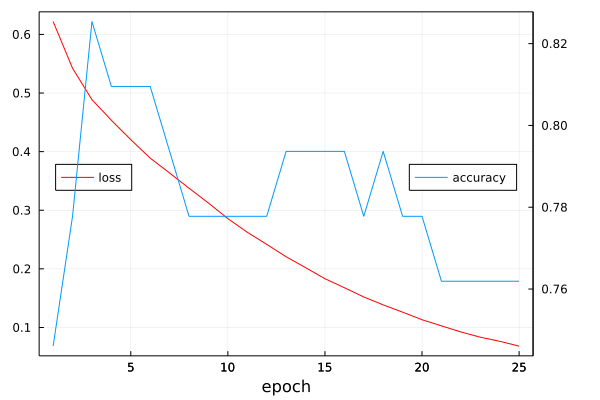

In [14]:
using Plots
plot(loss_vector, label="loss", legend=:left, color=:red, rightmargin = 1.5Plots.cm, bottommargin = 0.5Plots.cm, box = :on)
plot!(twinx(), accuracy_vector, label="accuracy", legend=:right, xlabel="epoch")